<b>Описание проекта</b>

Требуется выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

<b>Описание данных</b>

    Name — название игры
    Platform — платформа
    Year_of_Release — год выпуска
    Genre — жанр игры
    NA_sales — продажи в Северной Америке (миллионы проданных копий)
    EU_sales — продажи в Европе (миллионы проданных копий)
    JP_sales — продажи в Японии (миллионы проданных копий)
    Other_sales — продажи в других странах (миллионы проданных копий)
    Critic_Score — оценка критиков (максимум 100)
    User_Score — оценка пользователей (максимум 10)
    Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

### Открытие файла с данными и изучение общей информации

#### Используемые библиотеки и функции

In [1]:
import pandas as pd
import numpy as np 
from scipy import stats as st
import math
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
# Вывод информации о структуре датафрейма
def df_info(df):
    all_data = df.reset_index(drop=True)    
    all_data_na = (all_data.isna().sum() / len(all_data))
    missing_data = pd.DataFrame({'тип': df.dtypes})
    if len(all_data_na[all_data_na!=0])>0:
        missing_data['пропуски']= all_data_na.map("{:.1%}".format)
        display(missing_data)
        print('Столбцов с NA:',len(all_data_na[all_data_na!=0]),'из',df.shape[1])
    else:
        display(missing_data)
        print('Пропусков нет.') 
    if df.duplicated().sum()>0:
        print('Дубликатов:',df.duplicated().sum())
    else:
        print('Дубликатов нет')
    print(f'Структура : {all_data.shape}')
    
# Метод позволяет определить наименьший тип данных, для ускорения вычислений датафрейма и уменьшения занимаемой памяти
def type_optimize(df):
    for col in df.columns:
        if df[col].dtypes.kind == 'i' or df[col].dtypes.kind == 'u':
            if df[col].min() >= 0:
                df[col] = pd.to_numeric(df[col], downcast='unsigned')
            else:
                df[col] = pd.to_numeric(df[col], downcast='integer')
        elif df[col].dtypes.kind == 'f' or df[col].dtypes.kind == 'c':
            df[col] = pd.to_numeric(df[col], downcast='float')
        elif df[col].dtypes.kind == 'O':
            num_unique_values = len(df[col].unique())
            num_total_values = len(df[col])
            if num_unique_values / num_total_values < 0.5:
                df[col] = df[col].astype('category')
    print(df.dtypes)

# Функция для категоризации столбцов
def col_cat(df,col,col2=0,catn=1):
    df[col+'_id']=df[col]
    if catn==1:
        col2=df[col].unique() if col2==0 else col2
        un_val=dict(enumerate(col2))
        df.loc[df[col+'_id'].notna(),col+'_id'] = df.loc[df[col+'_id'].notna(),col+'_id'].map(dict(zip(un_val.values(),un_val.keys()))).astype('uint8')
        df[col+'_id']=pd.to_numeric(df[col+'_id'], errors='coerce')
    else:
        #catn=catn-1
        def fgrcalc(num):
            for i in range(1,catn+1):
                if (num>=lst[i-1] and num<=lst[i]):
                    return i  
        filtered=df.loc[df[col].notna(),col]
        lst=[filtered.min()]+[filtered.sort_values().to_list()[round(len(filtered)/catn)*i-2] for i in range(1,catn)]+[filtered.max()]
        print(lst)
        df.loc[df[col].notna(),col+'_id']=filtered.map(fgrcalc)
        tst=filtered.map(fgrcalc)
        print(tst[tst.isna()])
    return df

# Поиск и замена пропущенных значений датафрейма по коррелируемым признакам   
def filldf(df2,cat):
    def fgrcalc(num):
        for i in range(1,cat+1):
            if (num>=lst[i-1] and num<=lst[i]):
                return i     
    res= pd.DataFrame(columns=['столбец','восстановлено','осталось','по_значениям','корреляция'])
    global lst
    min_cor=0.40
    df3=df2.copy()
    dfcor=df2.corr()
    for col in df2.columns:
        if (df[col].isna().sum()>0) and (col in dfcor.columns):
            na=df[col].isna().sum()
            cr=dfcor[col]
            cr_i=cr.loc[(cr>=min_cor-.01) & (cr<1)]
            cr=cr_i.index.sort_values(ascending=False).to_list()
            if len(cr)>0:                
                for i in cr:
                    if i+'_id' not in df3.columns:
                        lst=[0]+[df2[col].sort_values().to_list()[round(df2.shape[0]/cat)*i-2] for i in range(1,cat+1)]
                        df3[i+'_id']=df2[col].map(fgrcalc)                
                df2[col]=df2[col].fillna(df3.groupby([i+'_id' for i in cr])[col].transform('median'))
                df2[col]=df2[col].fillna(df3.groupby(cr)[col].transform('median'))
                for i in cr:
                    df2[col]=df2[col].fillna(df3.groupby(i)[col].transform('median'))
                res.loc[len(res.index)]=[col,na-df2[col].isna().sum(),df2[col].isna().sum(),cr,"{:.0%}".format(cr_i.max())]
    print("Значение минимальной корреляции -","{:.0%}".format(min_cor))
    display(res.sort_values(by='корреляция', ascending=False).head(20))
    return df2

# Получение датасета с долями от продаж
def sales_parts(df,col,five=True,corr=False):
    units=df[[col,'total_sales']].groupby(col).sum().sort_values(by='total_sales',ascending=False).index.to_list()[:5]
    table=df.loc[df[col].isin(units),[col,'na_sales','eu_sales','jp_sales']].groupby(col).sum()
    table['na_sales'+'_part']=table.na_sales.div(table.na_sales.sum())
    table['eu_sales'+'_part']=table.eu_sales.div(table.eu_sales.sum())
    table['jp_sales'+'_part']=table.jp_sales.div(table.jp_sales.sum())
    #table=table.reset_index()
    table=table.iloc[:5,3:] if five else table.iloc[:,3:]
    return table

#### Изучение открытых файлов

In [3]:
df = pd.read_csv('/datasets/games.csv')
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
df_info(df)

,тип,пропуски
Name,object,0.0%
Platform,object,0.0%
Year_of_Release,float64,1.6%
Genre,object,0.0%
NA_sales,float64,0.0%
EU_sales,float64,0.0%
JP_sales,float64,0.0%
Other_sales,float64,0.0%
Critic_Score,float64,51.3%
User_Score,object,40.1%


Столбцов с NA: 6 из 11
Дубликатов нет
Структура : (16715, 11)


### Подготовка данных

Переименование столбцов

In [5]:
df.columns=[i.lower() for i in df.columns]
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

Изучение данных по столбцам на наличие выбросов. Категоризация.

In [6]:
df.platform.unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

Проведем категоризацию

In [7]:
df=col_cat(df,'platform')
df.sample(2)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,platform_id
9469,F1 2011,PSV,2011.0,Racing,0.03,0.07,0.01,0.02,66.0,6.2,E,22
9974,DEATH NOTE: Kira Game,DS,2007.0,Adventure,0.00,0.00,0.12,0.00,NaN,NaN,NaN,3


In [8]:
df.genre.unique()

array(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy', nan], dtype=object)

In [9]:
df=col_cat(df,'genre')
df.sample(2)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,platform_id,genre_id
1580,Kung Fu Panda,DS,2008.0,Action,0.56,0.56,0.00,0.14,NaN,NaN,NaN,3,8.0
3283,Fire Emblem: Shadow Dragon,DS,2008.0,Role-Playing,0.29,0.02,0.27,0.03,81.0,7,E10+,3,3.0


In [10]:
df.na_sales.value_counts()

0.00    4508
0.02     576
0.03     561
0.04     549
0.01     545
        ... 
4.98       1
4.21       1
6.82       1
5.05       1
9.00       1
Name: na_sales, Length: 402, dtype: int64

In [11]:
df.eu_sales.value_counts()

0.00    5870
0.01    1494
0.02    1308
0.03     926
0.04     709
        ... 
3.59       1
4.02       1
2.24       1
2.27       1
3.75       1
Name: eu_sales, Length: 307, dtype: int64

In [12]:
df.jp_sales.value_counts()

0.00    10514
0.02      741
0.01      706
0.03      546
0.04      397
        ...  
1.16        1
2.12        1
7.20        1
2.17        1
6.50        1
Name: jp_sales, Length: 244, dtype: int64

In [13]:
df.other_sales.value_counts()

0.00    6601
0.01    3464
0.02    1618
0.03     926
0.04     654
        ... 
0.96       1
1.93       1
0.97       1
1.37       1
1.06       1
Name: other_sales, Length: 155, dtype: int64

In [14]:
df.critic_score.describe()

count    8137.000000
mean       68.967679
std        13.938165
min        13.000000
25%        60.000000
50%        71.000000
75%        79.000000
max        98.000000
Name: critic_score, dtype: float64

In [15]:
df.user_score.value_counts()

tbd    2424
7.8     324
8       290
8.2     282
8.3     254
       ... 
1.9       2
0.7       2
1         2
0         1
9.7       1
Name: user_score, Length: 96, dtype: int64

Оценка tbd расшифровывается как to be determined - пока не определён. Заменим на NaN

In [16]:
df['user_score'].replace('tbd', np.nan, inplace=True)

In [17]:
df['user_score']=pd.to_numeric(df['user_score'], errors='coerce')
df['user_score'].describe()

count    7590.000000
mean        7.125046
std         1.500006
min         0.000000
25%         6.400000
50%         7.500000
75%         8.200000
max         9.700000
Name: user_score, dtype: float64

Изучим имеющиеся рейтинги

In [18]:
df['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

Заменим устаревшие рейтинги на актуальные, а также признак отсутствия рейтинга RP на NaN. Отсортируем рейтинг по возрастному ограничению и проведем категоризацию.

In [19]:
df['rating'].replace('K-A', 'E', inplace=True)
df['rating'].replace('RP', np.nan, inplace=True)

In [20]:
esrb=['EC', 'E', 'E10+', 'T', 'M', 'AO']
df=col_cat(df,'rating', esrb)
df.sample(2)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,platform_id,genre_id,rating_id
7797,Jikkyou Powerful Pro Yakyuu '96 Kaimakuban,SNES,1996.0,Sports,0.00,0.00,0.19,0.00,NaN,NaN,NaN,7,0.0,NaN
7224,Ultimate Band,DS,2008.0,Misc,0.19,0.02,0.00,0.02,69.0,NaN,E,3,5.0,1.0


Посмотрим на пропуски

In [21]:
df_info(df)

,тип,пропуски
name,object,0.0%
platform,object,0.0%
year_of_release,float64,1.6%
genre,object,0.0%
na_sales,float64,0.0%
eu_sales,float64,0.0%
jp_sales,float64,0.0%
other_sales,float64,0.0%
critic_score,float64,51.3%
user_score,float64,54.6%


Столбцов с NA: 8 из 14
Дубликатов нет
Структура : (16715, 14)


Попробуем восствановить пропуски по корреляции смежных значений

In [22]:
col=list(df.columns)
[col.remove(i) for i in ['name','platform','genre','rating']]
#df[col]=filldf(df[col],9)

[None, None, None, None]

Получилось восстановить не все значения, попробуем выяснить причины и дополнить вариации восстановления путем категоризации данных.

In [23]:
df=col_cat(df,'critic_score',catn=10)
df=col_cat(df,'user_score',catn=10)
df['total_score']=df[['critic_score_id','user_score_id']].mean(axis=1)
df=col_cat(df,'total_score',catn=10)

[13.0, 50.0, 58.0, 63.0, 67.0, 71.0, 74.0, 78.0, 81.0, 85.0, 98.0]
Series([], Name: critic_score, dtype: int64)
[0.0, 5.1, 6.0, 6.7, 7.1, 7.5, 7.8, 8.1, 8.3, 8.7, 9.7]
Series([], Name: user_score, dtype: int64)
[1.0, 1.5, 2.5, 3.5, 4.5, 5.0, 6.0, 7.0, 7.5, 9.0, 10.0]
Series([], Name: total_score, dtype: int64)


In [24]:
df['critic_score_id'].unique()

array([ 7., nan,  9.,  8., 10.,  2.,  3.,  6.,  5.,  1.,  4.])

Посмотрим корреляцию столбцов с пропущенными значениями

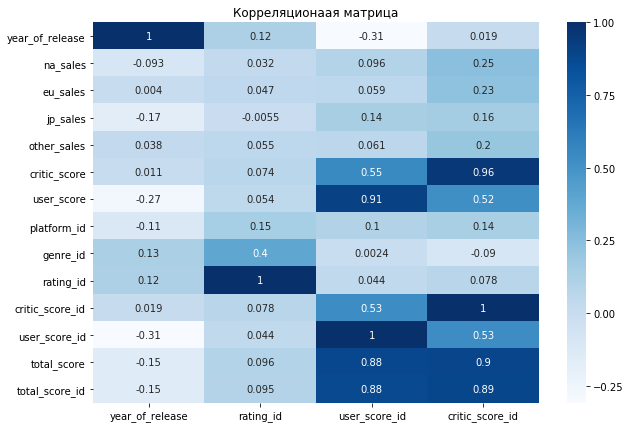

In [25]:
plt.figure(figsize = (10,7))
sns.heatmap(df.corr()[['year_of_release','rating_id','user_score_id','critic_score_id']], cmap = 'Blues', annot = True)
plt.title('Корреляционаая матрица')
plt.show() 

Посмотрим разброс значений на признаки по которым можно провести восстановление

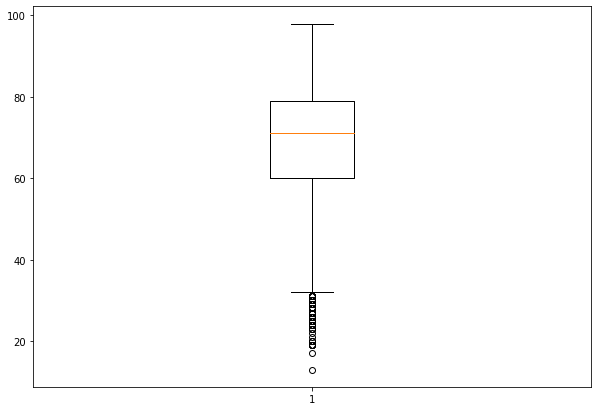

In [26]:
plt.figure(figsize = (10,7))
plt.boxplot(df.loc[~np.isnan(df['critic_score']),'critic_score'])
plt.show()

In [27]:
df['critic_score'].describe()

count    8137.000000
mean       68.967679
std        13.938165
min        13.000000
25%        60.000000
50%        71.000000
75%        79.000000
max        98.000000
Name: critic_score, dtype: float64

In [28]:
df.loc[(df.critic_score.isna()) & (df.user_score.isna())].shape[0]

8005

Часть значений не была восстановлена т.к коррелируемые признаки имеют смежные пропуски.

In [29]:
#df['user_score_id']=df['user_score_id'].fillna(df.groupby('rating_id')['user_score_id'].transform('median'))

Проведем оптимизацию типов

In [30]:
type_optimize(df)

name                 object
platform           category
year_of_release     float32
genre              category
na_sales            float32
eu_sales            float32
jp_sales            float32
other_sales         float32
critic_score        float32
user_score          float32
rating             category
platform_id           uint8
genre_id            float32
rating_id           float32
critic_score_id     float32
user_score_id       float32
total_score         float32
total_score_id      float32
dtype: object


Изменим тип year_of_release с float на int. Для этого избавимся от пропусков. Т.к их незначительно, то удаляем.

In [31]:
df.dropna(subset = ['year_of_release'], inplace = True)
df['year_of_release']=df['year_of_release'].astype('int')
df['platform']=df['platform'].astype('object')
df['rating']=df['rating'].astype('object')
df['genre']=df['genre'].astype('object')

Посмотрим конечное количество пропусков и типы данных после всех манипуляций.

In [32]:
df_info(df)

,тип,пропуски
name,object,0.0%
platform,object,0.0%
year_of_release,int64,0.0%
genre,object,0.0%
na_sales,float32,0.0%
eu_sales,float32,0.0%
jp_sales,float32,0.0%
other_sales,float32,0.0%
critic_score,float32,51.5%
user_score,float32,54.6%


Столбцов с NA: 11 из 18
Дубликатов нет
Структура : (16446, 18)


**Вывод:** Приведены в порядок типы данных, заголовки, заполнены пропуска. Часть пропусков восстановить не удалось, они оставлены, т.к их удаление приведет к значимой потере данных. Возможная причина пропусков - отсутствие данных(рейтинга).

### Исследовательский анализ данных

#### Количество игр выпускавшиеся в разные годы

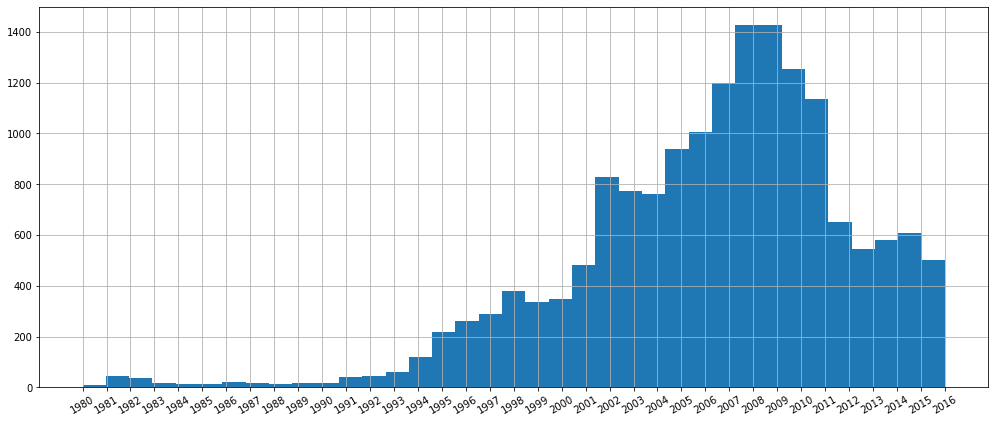

In [33]:
df['year_of_release'].hist(bins=37,figsize = (17,7))
plt.xticks(np.arange(1980,2017,step=1),rotation=30)
plt.show()

Как видно из графика до 1991 выпускалось  очень мало игр, данные с этими годами являются малоинформативными. Максимум выпуска игр приходится на 2007-2009 г.

#### Изменения продаж по платформам

создадим столбец с общим итогом продаж

In [34]:
df['total_sales']=df.loc[:, 'na_sales':'other_sales'].sum(axis=1)
df.sample(2)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,platform_id,genre_id,rating_id,critic_score_id,user_score_id,total_score,total_score_id,total_sales
7228,All-Star Baseball 2002,GC,2001,Sports,0.17,0.04,0.0,0.01,66.0,5.6,E,19,0.0,1.0,4.0,2.0,3.0,3.0,0.22
9302,Gladius,XB,2003,Strategy,0.10,0.03,0.0,0.00,79.0,8.5,T,13,11.0,3.0,8.0,9.0,8.5,9.0,0.13


Посмотрим топ-5 платформ по продажам

In [35]:
p_sales=df[['platform','total_sales']].groupby('platform').sum().sort_values(by='total_sales',ascending=False)
p_sales[0:5]

,total_sales
platform,
PS2,1233.559937
X360,961.239990
PS3,931.339966
Wii,891.179993
DS,802.780029


построим распределение по годам

In [36]:
pl=p_sales[:1].index[0]
print('Platform: ',pl)
df.loc[df.platform==pl,['year_of_release','total_sales']].groupby('year_of_release').sum()\
    .sort_values(by='total_sales',ascending=False)

Platform:  PS2


,total_sales
year_of_release,
2004,211.809998
2002,205.380005
2003,184.309998
2001,166.430008
2005,160.660004
2006,103.419998
2007,75.989998
2008,53.900002
2000,39.170002


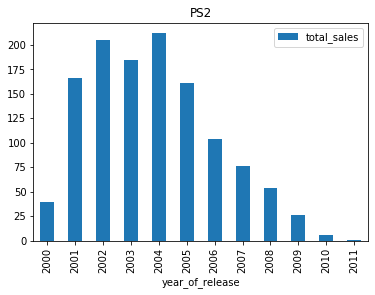

In [37]:
df.loc[df.platform==pl,['year_of_release','total_sales']].groupby('year_of_release').sum().plot(kind="bar",title=pl)

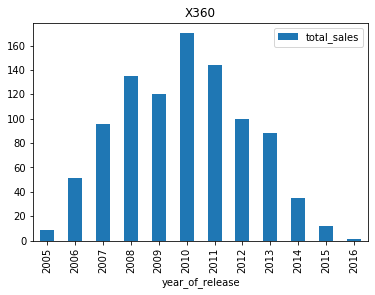

In [38]:
pl=p_sales[1:2].index[0]
df.loc[df.platform==pl,['year_of_release','total_sales']].groupby('year_of_release').sum().plot(kind="bar",title=pl)

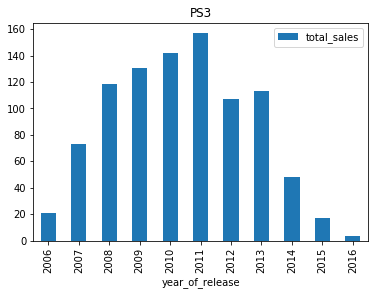

In [39]:
pl=p_sales[2:3].index[0]
df.loc[df.platform==pl,['year_of_release','total_sales']].groupby('year_of_release').sum().plot(kind="bar",title=pl)

Возьмем платформы из средних продаж и посмотрим на их сроки жизни

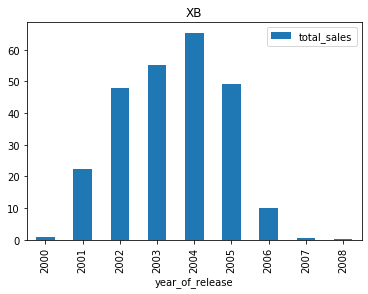

In [40]:
pl=p_sales[p_sales.shape[0]//2-3:p_sales.shape[0]//2-2].index[0]
df.loc[df.platform==pl,['year_of_release','total_sales']].groupby('year_of_release').sum().plot(kind="bar",title=pl)

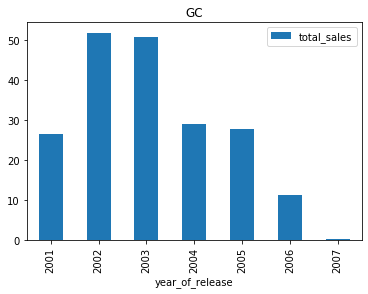

In [41]:
pl=p_sales[p_sales.shape[0]//2+1:p_sales.shape[0]//2+2].index[0]
df.loc[df.platform==pl,['year_of_release','total_sales']].groupby('year_of_release').sum().plot(kind="bar",title=pl)

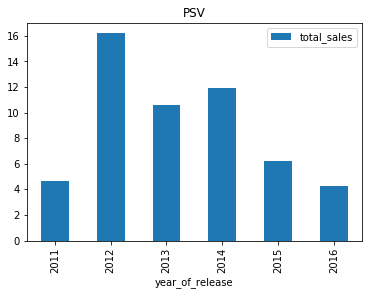

In [42]:
pl=p_sales[p_sales.shape[0]//2+5:p_sales.shape[0]//2+6].index[0]
df.loc[df.platform==pl,['year_of_release','total_sales']].groupby('year_of_release').sum().plot(kind="bar",title=pl)

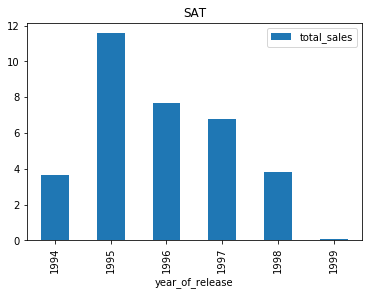

In [43]:
pl=p_sales[p_sales.shape[0]//2+6:p_sales.shape[0]//2+7].index[0]
df.loc[df.platform==pl,['year_of_release','total_sales']].groupby('year_of_release').sum().plot(kind="bar",title=pl)

Из графиков видно, что в среднем платформы из топ существуют 10 лет, а из середины продаж 6-7 лет. Максимум продаж за год приходится на середину срока существования. У платформ из середины график принимает вид нормального распределнгия скошенного вправо.

In [44]:
pd.pivot_table(df[df.year_of_release>2011],index='year_of_release',columns='platform',aggfunc={'total_sales':['sum']})\

total_sales                                                  \
                        sum                                                   
platform                3DS     DS         PC         PS3         PS4   PSP   
year_of_release                                                               
2012              51.360001  11.01  23.219999  107.360001         NaN  7.69   
2013              56.570000   1.54  12.380000  113.250000   25.990000  3.14   
2014              43.759998    NaN  13.280001   47.759998  100.000000  0.24   
2015              27.780001    NaN   8.520000   16.820000  118.900002  0.12   
2016              15.140000    NaN   5.250000    3.600000   69.250000   NaN   

                                                                        
                                                                        
platform               PSV        Wii       WiiU       X360       XOne  
year_of_release                                                         
2012             16.190001  21.710001  17.559999  99.739998        NaN  
2013             10.590000   8.590000  21.650000  88.580002  18.960001  
2014             11.900000   3.750000  22.030001  34.740002  54.070000  
2015              6.250000   1.140000  16.350000  11.960000  60.139999  
2016              4.250000   0.180000   4.600000   1.520000  26.150000

Построим график продаж за актуальный период. Актуальные года для изучения будем считать равные среднему продолжительности существования платформ, а промежуток времени для прогнозирования  выберем половину от срока жизни топ платформ, т.е. 5 лет. Т.к данные за 2016 не полные, будем рассматривать значения с 2011 года. 

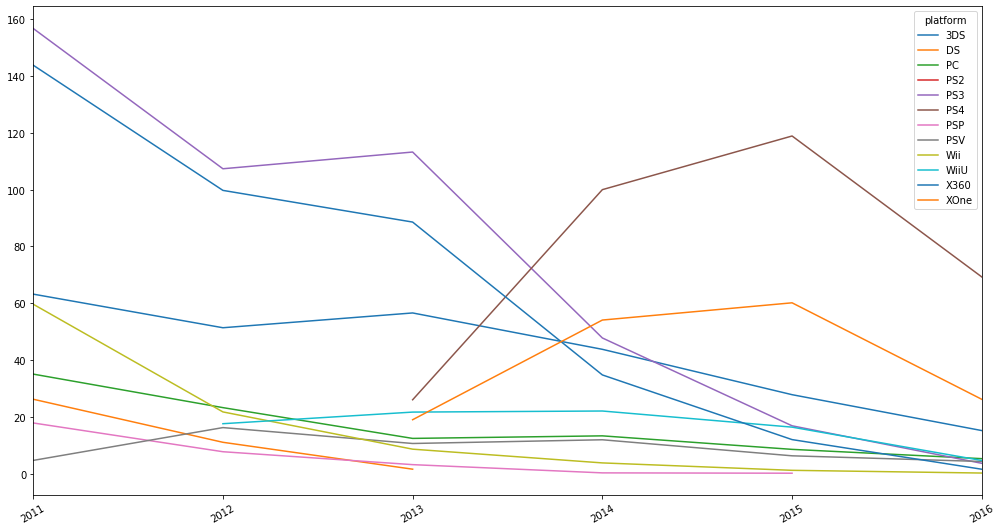

In [45]:
plts=pd.pivot_table(df[df.year_of_release>2010],index='year_of_release',columns='platform',aggfunc={'total_sales':['sum']})\
.unstack('year_of_release').unstack('year_of_release').reset_index().iloc[:,2:].set_index(['platform'])
plts.columns=[i for i in range(2011,2017)]
plts=plts.T
plts.plot(rot=30,figsize = (17,9))

Из графика видно, что максимум продаж(середина периода) приходится на PSV, 3DS, в дальнейшем их продажи будут падать. PS4, XOne, WiiU подходят к середине, возможен еще краткосрочный рост. В остальных случайях продажи платформ идут на спад. Мы не знаем к какому типу будет относиться будущие продажи за актуальный период временного ряда - топ или это будут средние продажи, но мы можем сделать прогноз исходя из бренда. Тут также будет полезно учитывать, что даже на растущие продажи оказывает влияние понижающийся тренд по продажам на всех платформах, т.е если мы видим прогноз роста по новым платформам, он не будет такой как на пике продаж в 2007-2008 гг.

Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


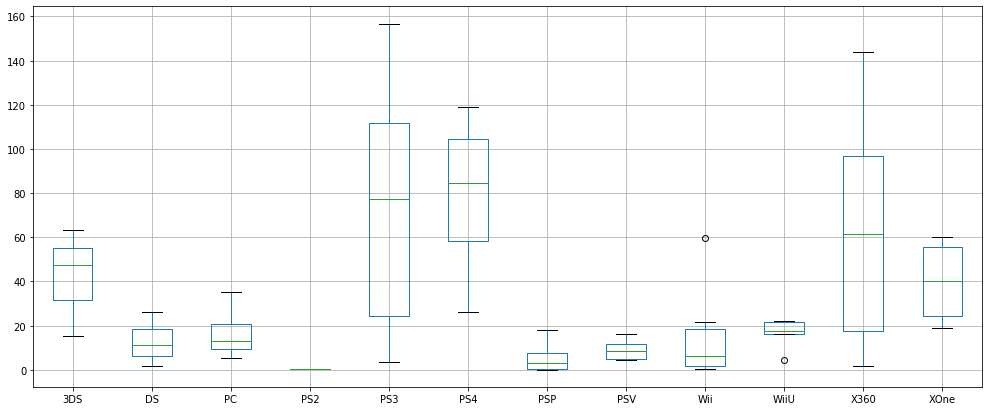

In [46]:
plts=pd.pivot_table(df[df.year_of_release>2010],index='year_of_release',columns='platform',aggfunc={'total_sales':['sum']})\
.unstack('year_of_release').unstack('year_of_release').reset_index().iloc[:,2:].set_index(['platform'])
plts.columns=[i for i in range(2011,2017)]
plts=plts.T
plt.figure(figsize = (17,7))
plts.boxplot(column=list(plts.columns))  
plt.show()

In [47]:
pd.pivot_table(df[df.year_of_release>2010],index='year_of_release',columns='platform',aggfunc={'total_sales':['sum']})

total_sales                                                  \
                        sum                                                   
platform                3DS     DS         PC   PS2         PS3         PS4   
year_of_release                                                               
2011              63.199997  26.18  35.029999  0.45  156.779999         NaN   
2012              51.360001  11.01  23.219999   NaN  107.360001         NaN   
2013              56.570000   1.54  12.380000   NaN  113.250000   25.990000   
2014              43.759998    NaN  13.280001   NaN   47.759998  100.000000   
2015              27.780001    NaN   8.520000   NaN   16.820000  118.900002   
2016              15.140000    NaN   5.250000   NaN    3.600000   69.250000   

                                                                                
                                                                                
platform           PSP        PSV        Wii       WiiU        X360       XOne  
year_of_release                                                                 
2011             17.82   4.630000  59.649998        NaN  143.839996        NaN  
2012              7.69  16.190001  21.710001  17.559999   99.739998        NaN  
2013              3.14  10.590000   8.590000  21.650000   88.580002  18.960001  
2014              0.24  11.900000   3.750000  22.030001   34.740002  54.070000  
2015              0.12   6.250000   1.140000  16.350000   11.960000  60.139999  
2016               NaN   4.250000   0.180000   4.600000    1.520000  26.150000

За актуальный период наибольший обьем продаж у PS4, PS3 и X360. Худшие продажи у PS2, PSP и PSV.

Посмотрим на влияние отзывов на продажи платформы PS3

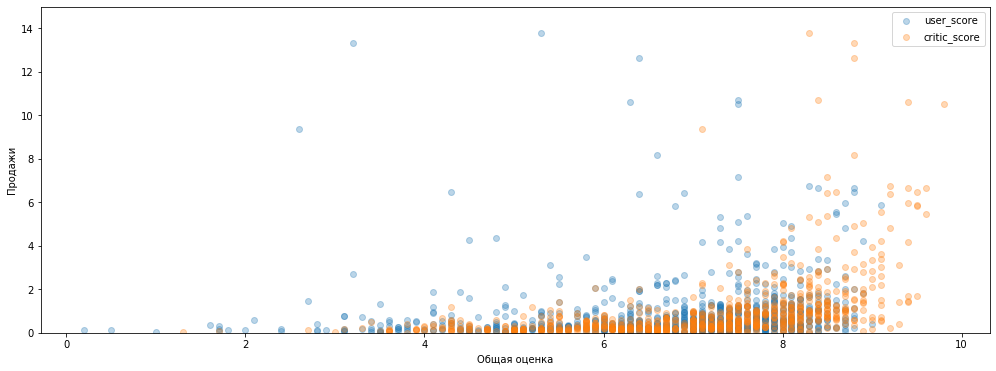

In [48]:
ps3=df[df.platform=='PS3']
fig , ax = plt.subplots(nrows = 1, ncols = 1,figsize=(17,6))  
ax.scatter(ps3['user_score'], ps3['total_sales'],alpha=0.3,label='user_score')
ax.scatter(ps3['critic_score'].div(10), ps3['total_sales'],alpha=0.3,label='critic_score')
ax.set_xlabel('Общая оценка')
ax.set_ylabel('Продажи')
ax.set_ylim(0,15)
ax.legend()
plt.show()

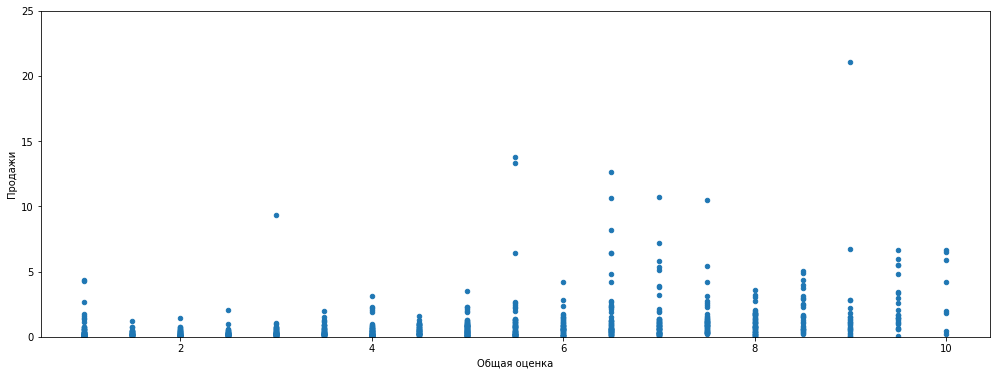

In [49]:
ps3.plot(x='total_score', y='total_sales', kind='scatter', ylim=(0,25),figsize = (17,6))
plt.xlabel('Общая оценка')
plt.ylabel('Продажи')
plt.show()

На графике прослеживается зависимость продаж от оценок, с увеличением оценок растут продажи. Оценка пользователей от средней и выше влияет сильней на продажи некоторых игр, чем оценки критиков. Но при оценках критиков от 80 баллов и выше продажи идут больше, чем от оценок пользователей.

Посмотрим зависимость продаж от оценок и посчитаем корреляцию.

In [50]:
pd.DataFrame(ps3[['user_score','critic_score','total_score','total_sales']].corr().iloc[:3,3])

,total_sales
user_score,0.128416
critic_score,0.432759
total_score,0.337301


Корреляция продаж по оценкам присутствует и она положительная. Наиболее выраженная корреляция по оценкам критиков, по оценкам пользователей корреляция довольно слабая.

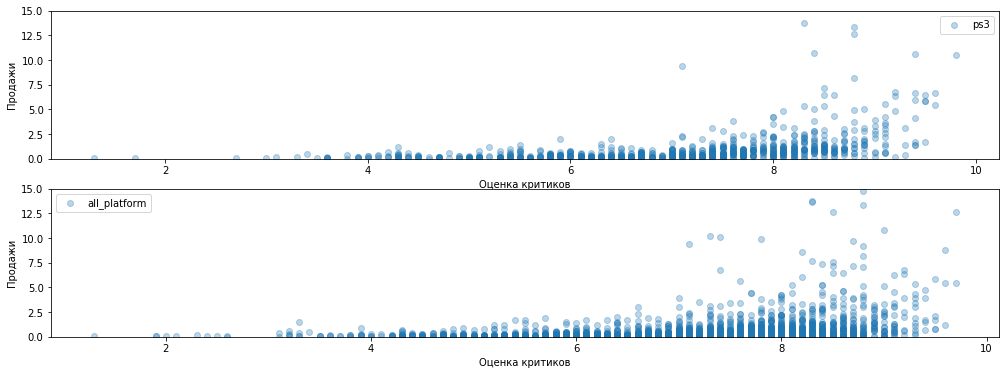

In [51]:
fig , ax = plt.subplots(nrows = 2, ncols = 1,figsize=(17,6))  
ax[0].scatter(ps3['critic_score'].div(10), ps3['total_sales'],alpha=0.3,label='ps3')
ax[0].set_xlabel('Оценка критиков')
ax[0].set_ylabel('Продажи')
ax[0].set_ylim(0,15)
ax[0].legend()
ax[1].scatter(df.loc[df.year_of_release>2010,'critic_score'].div(10), df.loc[df.year_of_release>2010,'total_sales'],alpha=0.3,label='all_platform')
ax[1].set_xlabel('Оценка критиков')
ax[1].set_ylabel('Продажи')
ax[1].set_ylim(0,15)
ax[1].legend()
plt.show()

Графики продаж и оценок пользователей для всех платформ и ps3 имеют схожую структуру - нормальное распределение сильно скошенное в лево. По всем платформам продажи выражены сильнее, это обусловлено большим количеством данных, чем для платформы ps3. 

In [52]:
pd.DataFrame(df.loc[df.year_of_release>2010,['user_score','critic_score','total_score','total_sales']].corr().iloc[:3,3])

,total_sales
user_score,0.031636
critic_score,0.329977
total_score,0.221002


По всем платформам корреляция схожая, но немного слабее.

Посмотрим на общее распределение игр по жанрам.

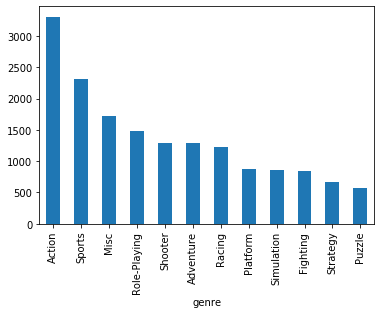

In [53]:
df.groupby('genre')['total_sales'].count().sort_values(ascending=False).plot(kind='bar')

In [54]:
df.groupby('genre')['total_sales'].count().sort_values(ascending=False).index.to_list()[:5]

['Action', 'Sports', 'Misc', 'Role-Playing', 'Shooter']

Самые распространенные жанры 'Action', 'Sports', а самые не популярные Strategy и Puzzle.

Посмотрим продажи по жанрам.

In [55]:
df[['total_sales']].median()#.groupby('genre').median()

total_sales    0.17
dtype: float32

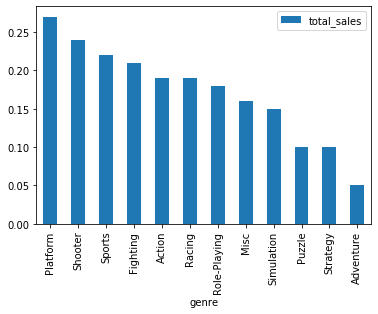

In [56]:
df[['genre','total_sales']].groupby('genre').median().sort_values(by='total_sales',ascending=False).plot(kind='bar')

По продажам также выделяются в лидерах 'Platform', 'Shooter', а в аутсайдерах 'Adventure' и 'Strategy', их продажи в 6 раз меньше.

### Портрет пользователя каждого региона

#### Определение протрета пользователя каждого региона (NA, EU, JP)

Самые популярные платформы (топ-5)

In [57]:
sales_parts(df,'platform')

,na_sales_part,eu_sales_part,jp_sales_part
platform,,,
DS,0.156766,0.137036,0.370374
PS2,0.236161,0.241932,0.291059
PS3,0.160814,0.237990,0.168046
Wii,0.200691,0.187884,0.144493
X360,0.245568,0.195157,0.026029


Топ-5 популярных платформ: DS, PS2, PS3, Wii, X360

Посмотрим график распределения платформ по регионам.

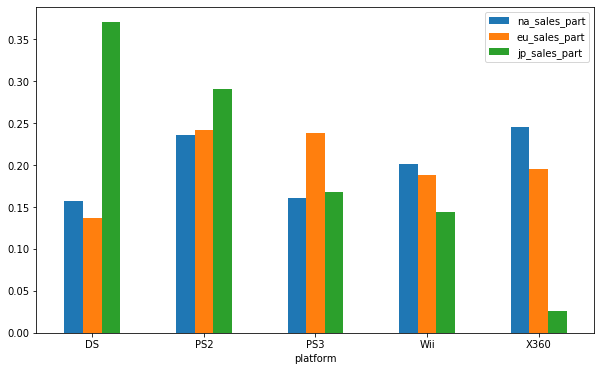

In [58]:
sales_parts(df,'platform').plot.bar(figsize = (10,6),rot=0)

Америка:
* популярные - X360, PS2
* непопулярные - PS3, DS

Европа:
* популярные - PS3, PS2
* непопулярные - DS

Япония: 
* популярные - DS, PS2
* непопулярные - X360

В целом для Европы и Америки дисперсия по продажам не сильно большая, а вот для Японии характерны очень слабые продажи X360.

Самые популярные жанры и их распределение представлены ниже на графике

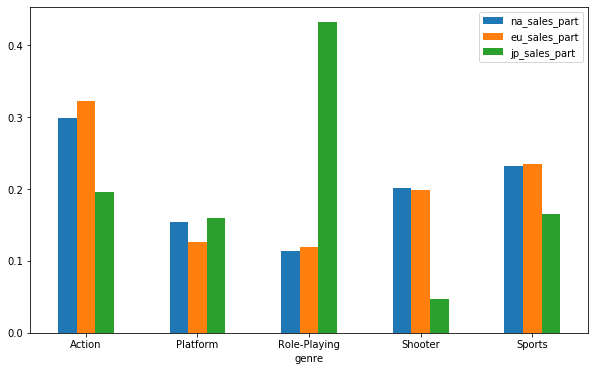

In [59]:
sales_parts(df,'genre').plot.bar(figsize = (10,6),rot=0)

В Японии любят ролевые игры и не любят шутеры. В Европе и Америке предпочитают игры жанра Action и не очень любят ролевые игры. В целом распределение Европы и Америки схожее.

Рассмотрим влияние рейтинга ESRB на продажи в отдельном регионе.

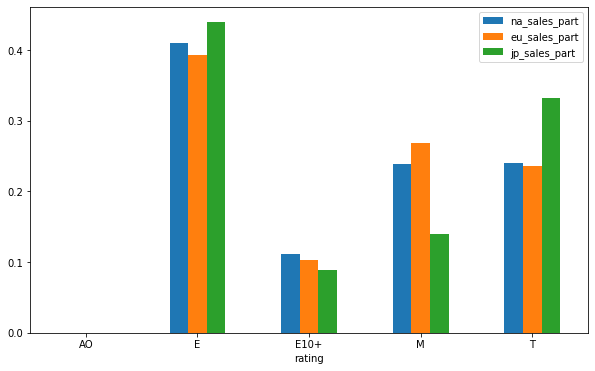

In [60]:
sales_parts(df,'rating',False).plot.bar(figsize = (10,6),rot=0)
#['EC', 'E', 'E10+', 'T', 'M', 'AO']

Самый популярный рейтинг во всех регионах - E, менеее  AO, E10+. Сильное влияние E обусловлено широкой аудиторией охвата (E-для всех). В целом влияние рейтингов в регионах одинаковое, выделяется немного Япония - в рейтинг M и T.

На основании выше изложенного проверим корреляцию по рейтингу.

In [61]:
df[['rating_id','na_sales','eu_sales','jp_sales']].corr().iloc[1:4,:1]

,rating_id
na_sales,0.033466
eu_sales,0.046881
jp_sales,-0.006077


In [62]:
raiting_cor=sales_parts(df,'rating_id',corr=True).reset_index()
raiting_cor.corr().iloc[1:,:1]

,rating_id
na_sales_part,-0.709696
eu_sales_part,-0.644329
jp_sales_part,-0.723481


In [63]:
raiting_cor

,rating_id,na_sales_part,eu_sales_part,jp_sales_part
0,1.0,0.410013,0.393398,0.439348
1,2.0,0.110949,0.102436,0.088566
2,3.0,0.240073,0.235651,0.332011
3,4.0,0.238561,0.268173,0.140075
4,5.0,0.000405,0.000341,0.000000


Корреляция подтвердила уже сделанные выводы - с увеличением рейтинга и огрничений продажи уменьшаются.

Посмотрим какие игры удовлетворяют перспективным направлениям.

In [81]:
df.loc[(df.platform.isin(['PS4', 'XOne', 'WiiU'])) & (df.genre.isin(['Platform','Shooter'])) & (df.rating=='E'),'name'].tolist()

['New Super Mario Bros. U',
 'Super Mario 3D World',
 'Super Mario Maker',
 'New Super Luigi U',
 'LittleBigPlanet 3',
 'Donkey Kong Country: Tropical Freeze',
 "Yoshi's Woolly World",
 'Kirby and the Rainbow Curse',
 'Tearaway Unfolded',
 'Shovel Knight',
 'The Smurfs 2',
 'Shovel Knight',
 'Mega Man Legacy Collection']

### Проверка гипотез

#### Гипотеза: средние пользовательские рейтинги платформ Xbox One и PC одинаковые.
<i>Нулевая гипотеза</i> - средние пользовательские рейтинги платформ Xbox One и PC совпадают.

<i>Альтернативная гипотеза</i> - средние пользовательские рейтинги платформ Xbox One и PC различаются.

In [64]:
score_x=df.loc[(df.platform=='XOne') & (df.user_score.notna()),'user_score']
score_pc=df.loc[(df.platform=='PC') & (df.user_score.notna()),'user_score']

посмотрим средние значения по рейтингам

In [65]:
score_x.mean()

6.521428

In [66]:
score_pc.mean()

7.06596

посмотрим дисперсии

In [67]:
score_x.var()

1.9069968

In [68]:
score_pc.var()

2.3492243

проверим гипотезы

In [69]:
st.ttest_ind(score_x, score_pc,equal_var = True).pvalue

1.3037915455737523e-05

Так как pvalue меньше .05 отвергаем нулевую гипотезу.

#### Средние пользовательские рейтинги жанров Action и Sports разные.
<i>Нулевая гипотеза</i> - средние пользовательские рейтинги жанров Action и Sports совпадают.

<i>Альтернативная гипотеза</i> - средние пользовательские рейтинги жанров Action и Sports различаются.

In [70]:
score_action=df.loc[(df.genre=='Action') & (df.user_score.notna()),'user_score']
score_sport=df.loc[(df.genre=='Sports') & (df.user_score.notna()),'user_score']

посмотрим средние значения по рейтингам

In [71]:
score_action.mean()

7.0581293

In [72]:
score_sport.mean()

6.9514337

посмотрим дисперсии

In [73]:
score_action.var()

2.0274937

In [74]:
score_sport.var()

2.623056

проверим гипотезы

In [75]:
st.ttest_ind(score_action, score_sport,equal_var = True).pvalue

0.06480844447220012

Так как pvalue больше .05 не отвергаем нулевую гипотезу.

### Общий вывод

1. Определены перспективные платформы - PS4, XOne.
2. Самые популярные жанры - Platform, Shooter.
3. Самый продаваемый рейтинг ESRB - E.
4. На продажи влияет рейтинг пользователей и критиков, но большая зависимость от критиков.
5. Япония имеет свои отличительные особенности и выделяется в продажах игр.
6. Средние пользовательские рейтинги платформ Xbox One и PC различаются.
7. Средние пользовательские рейтинги жанров Action и Sports совпадают.

**Рекомендации на 2017 год:**
* платформы:
 * XOne 
 * PS4 
 * WiiU 
* жанр: Platform, Shooter
* рейтинг: E

Игры удовлетворяющие перспективным направлениям:
 * New Super Mario Bros. U
 * Super Mario 3D World
 * Super Mario Maker
 * New Super Luigi U
 * LittleBigPlanet 3
 * Donkey Kong Country: Tropical Freeze
 * Yoshi's Woolly World
 * Kirby and the Rainbow Curse
 * Tearaway Unfolded
 * Shovel Knight
 * The Smurfs 2
 * Shovel Knight
 * Mega Man Legacy Collection